<a href="https://colab.research.google.com/github/DanielWarfield1/MLWritingAndResearch/blob/main/Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("sparkApp") \
       .master("local[*]") \
       .getOrCreate()

spark

In [3]:
spark1 = SparkSession.builder.appName("AppOne").getOrCreate()
spark2 = SparkSession.builder.appName("AppTwo").getOrCreate()

print(spark1 is spark2)  # True — same session
print(spark2.sparkContext.appName)  # "AppOne"

True
sparkApp


In [4]:
from pyspark.sql import SparkSession

# First, we initialize a SparkSession and SparkContext
spark1 = SparkSession.builder.appName("sparkApp").getOrCreate()

# Create a DataFrame and a temporary view in spark1
df1 = spark1.createDataFrame([(1, "Alice"), (2, "Bob")], ["id", "name"])
df1.createOrReplaceTempView("people")

# Run SQL in spark1
print("Session 1:")
spark1.sql("SELECT * FROM people").show()

# Now create a separate session
spark2 = spark1.newSession()

# Session 2 does NOT see the temp view from session 1
print("Session 2 (before creating view):")
try:
    spark2.sql("SELECT * FROM people").show()
except Exception as e:
    print("Error:", e)

# Create a separate view in session 2
df2 = spark2.createDataFrame([(3, "Charlie")], ["id", "name"])
df2.createOrReplaceTempView("people")

print("Session 2 (after creating its own view):")
spark2.sql("SELECT * FROM people").show()

print("Back to Session 1:")
spark1.sql("SELECT * FROM people").show()

Session 1:
+---+-----+
| id| name|
+---+-----+
|  1|Alice|
|  2|  Bob|
+---+-----+

Session 2 (before creating view):
Error: [TABLE_OR_VIEW_NOT_FOUND] The table or view `people` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS.; line 1 pos 14;
'Project [*]
+- 'UnresolvedRelation [people], [], false

Session 2 (after creating its own view):
+---+-------+
| id|   name|
+---+-------+
|  3|Charlie|
+---+-------+

Back to Session 1:
+---+-----+
| id| name|
+---+-----+
|  1|Alice|
|  2|  Bob|
+---+-----+



# Creating a Simple RDD

In [6]:
# ---- Setup ----
spark = SparkSession.builder.appName("RDD Demo").getOrCreate()
sc = spark.sparkContext

# ---- Create an RDD ----
numbers = sc.parallelize([1, 2, 3, 4, 5])

# ---- Transformation: add 10 to each number ----
added = numbers.map(lambda x: x + 10)

# ---- Action: collect results back to the driver ----
result = added.collect()

print("Original numbers:", numbers.collect())
print("After adding 10:", result)

sc.stop()

Original numbers: [1, 2, 3, 4, 5]
After adding 10: [11, 12, 13, 14, 15]


In [10]:
from pyspark.sql import SparkSession

# ---- Setup ----
spark = SparkSession.builder.appName("RDD Demo").getOrCreate()
sc = spark.sparkContext

# ---- Create RDDs ----
numbers = sc.parallelize([1, 2, 3, 4, 5])

# ---- Transformations ----
squared = numbers.map(lambda x: x * x)
even_squares = squared.filter(lambda x: x % 2 == 0)

# ---- Reduce ----
total = numbers.reduce(lambda a, b: a + b)
total_even_squares = even_squares.reduce(lambda a, b: a + b)

# ---- Actions ----
print("Original numbers:", numbers.collect())
print("Squared:", squared.collect())
print("Even squares:", even_squares.collect())
print("Sum of numbers:", total)
print("Sum of even squares:", total_even_squares)

spark.stop()

Original numbers: [1, 2, 3, 4, 5]
Squared: [1, 4, 9, 16, 25]
Even squares: [4, 16]
Sum of numbers: 15
Sum of even squares: 20


In [10]:
# ---- Setup ----
spark = SparkSession.builder.appName("RDD Demo").getOrCreate()
sc = spark.sparkContext

numbers = sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
print(numbers.glom().collect())

[[1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15]]


# Caching

In [11]:
from pyspark.sql import SparkSession

# ---- Setup ----
spark = SparkSession.builder.appName("RDD Caching Demo").getOrCreate()
sc = spark.sparkContext

# ---- Create RDD ----
numbers = sc.parallelize(range(1, 11))  # 1 to 10

# ---- Transformations ----
squared = numbers.map(lambda x: x * x)
even_squares = squared.filter(lambda x: x % 2 == 0)

# -------------------------------
# Without caching: Spark recomputes each time
# -------------------------------
print("=== WITHOUT CACHING ===")
print("Squared:", squared.collect())          # triggers a Spark job
print("Even squares:", even_squares.collect()) # recomputes from numbers → squared → even_squares
print("Sum of even squares:", even_squares.reduce(lambda a, b: a + b))  # recomputes again

# -------------------------------
# With caching: Spark computes once and reuses results
# -------------------------------
squared_cached = numbers.map(lambda x: x * x).cache()
even_squares_cached = squared_cached.filter(lambda x: x % 2 == 0).cache()

print("\n=== WITH CACHING ===")
print("Squared (cached):", squared_cached.collect())            # first action → computed & cached
print("Even squares (cached):", even_squares_cached.collect())  # reused from cache, and result stored to cache
print("Sum of even squares (cached):", even_squares_cached.reduce(lambda a, b: a + b))  # reused cache

# ---- Clean up ----
spark.stop()


=== WITHOUT CACHING ===
Squared: [1, 4, 9, 16, 25, 36, 49, 64, 81, 100]
Even squares: [4, 16, 36, 64, 100]
Sum of even squares: 220

=== WITH CACHING ===
Squared (cached): [1, 4, 9, 16, 25, 36, 49, 64, 81, 100]
Even squares (cached): [4, 16, 36, 64, 100]
Sum of even squares (cached): 220


# Doing it with audio

In [12]:
import numpy as np
import soundfile as sf
import os

os.makedirs("test_audio", exist_ok=True)

# Parameters
sr = 22050  # sample rate
duration = 2.0  # seconds
t = np.linspace(0, duration, int(sr*duration), endpoint=False)

# Generate 3 different test signals
signals = {
    "sine440.wav": np.sin(2*np.pi*440*t),   # 440 Hz (A4)
    "sine880.wav": np.sin(2*np.pi*880*t),   # 880 Hz (A5)
    "sine_chord.wav": np.sin(2*np.pi*440*t) + np.sin(2*np.pi*660*t)  # simple chord
}

# Save as WAV files
for fname, sig in signals.items():
    sf.write(os.path.join("test_audio", fname), sig, sr)

print("Audio files written to ./test_audio")


Audio files written to ./test_audio


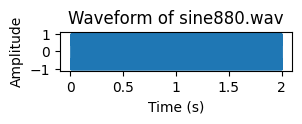

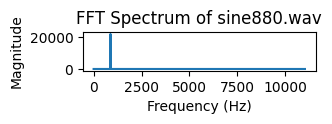

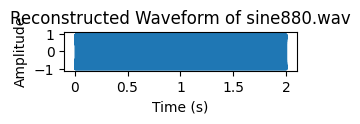

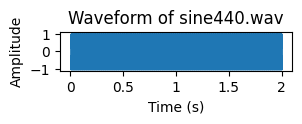

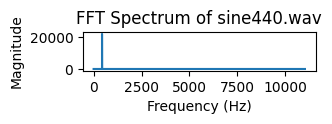

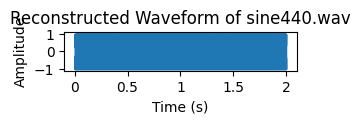

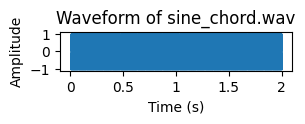

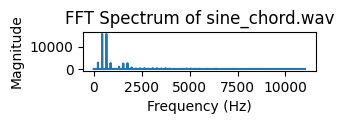

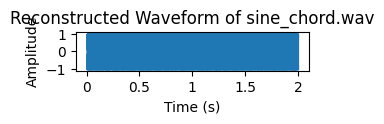

In [19]:
import matplotlib.pyplot as plt
import librosa

spark = SparkSession.builder.appName("Audio FFT DAG Demo").getOrCreate()
sc = spark.sparkContext

audio_files = [os.path.join("test_audio", f) for f in os.listdir("test_audio")]
rdd = sc.parallelize(audio_files)

# ==========================================
# Step 3. Define DAG transformations
# ==========================================
def load_audio(path, sr=22050):
    import librosa  # import inside worker
    y, sr = librosa.load(path, sr=sr)
    return (path, y, sr)

def compute_fft(item):
    import numpy as np  # import inside worker
    fname, y, sr = item
    fft_vals = np.fft.fft(y)
    return (fname, y, sr, fft_vals)

def compute_ifft(item):
    import numpy as np  # import inside worker
    fname, y, sr, fft_vals = item
    y_reconstructed = np.fft.ifft(fft_vals).real
    return (fname, y, sr, fft_vals, y_reconstructed)

# DAG
audio_rdd = rdd.map(load_audio).cache()
fft_rdd = audio_rdd.map(compute_fft).cache()
ifft_rdd = fft_rdd.map(compute_ifft).cache()

# ==========================================
# Step 4. Execute DAG + Collect
# ==========================================
results = ifft_rdd.collect()

# ==========================================
# Step 5. Plot results
# ==========================================
for fname, y, sr, fft_vals, y_reconstructed in results:
    # --- 1. Original waveform ---
    plt.figure(figsize=(3, 0.5))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform of {os.path.basename(fname)}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # --- 2. FFT spectrum ---
    fft_freqs = np.fft.fftfreq(len(fft_vals), 1/sr)
    plt.figure(figsize=(3, 0.5))
    plt.plot(fft_freqs[:len(fft_vals)//2], np.abs(fft_vals)[:len(fft_vals)//2])
    plt.title(f"FFT Spectrum of {os.path.basename(fname)}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.show()

    # --- 3. Reconstructed waveform ---
    plt.figure(figsize=(3, 0.5))
    librosa.display.waveshow(y_reconstructed, sr=sr)
    plt.title(f"Reconstructed Waveform of {os.path.basename(fname)}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

# ==========================================
# Step 6. Cleanup
# ==========================================
spark.stop()

# Downloading a Data Frame

In [3]:
import requests
path = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
req = requests.get(path)
url_content = req.content

csv_file_name = 'owid-covid-data.csv'
csv_file = open(csv_file_name, 'wb')

csv_file.write(url_content)
csv_file.close()

df = spark.read.csv('/content/'+csv_file_name, header=True, inferSchema=True)

In [ ]:
#Summary stats
df.describe().show()

+-------+--------+-------------+-----------+-------------------+-----------------+------------------+-----------------+------------------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+------------------+-----------------+------------------------+------------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-------------------+------------------+------------------------+----------------------+------------------+-------------------------------+-------------------+-----------------+-------------+-------------------+--------------------+-----------------------+--------------------+-----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+--------------------

In [ ]:
#DataFrame Filtering
df.filter(df.location == "United States").orderBy(F.desc("date")).show()

+--------+-------------+-------------+----------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+------------------------------+-------------------------

In [ ]:
#Simple Group by Function
df.groupBy("location").sum("new_cases").orderBy(F.desc("sum(new_cases)")).show(truncate=False)

+-----------------------------+--------------+
|location                     |sum(new_cases)|
+-----------------------------+--------------+
|World                        |775935057     |
|High-income countries        |429044052     |
|Asia                         |301564180     |
|Europe                       |252916868     |
|Upper-middle-income countries|251756125     |
|European Union (27)          |185822587     |
|North America                |124492698     |
|United States                |103436829     |
|China                        |99373219      |
|Lower-middle-income countries|92019711      |
|South America                |68811012      |
|India                        |45041748      |
|France                       |38997490      |
|Germany                      |38437756      |
|Brazil                       |37511921      |
|South Korea                  |34571873      |
|Japan                        |33803572      |
|Italy                        |26781078      |
|United Kingd

In [5]:
# Suppose df already exists
df.createOrReplaceTempView("covid_data")

spark.sql("""
    SELECT
        location,
        SUM(new_cases) AS total_new_cases
    FROM covid_data
    GROUP BY location
    ORDER BY total_new_cases DESC
""").show(truncate=False)

+-----------------------------+---------------+
|location                     |total_new_cases|
+-----------------------------+---------------+
|World                        |775935057      |
|High-income countries        |429044052      |
|Asia                         |301564180      |
|Europe                       |252916868      |
|Upper-middle-income countries|251756125      |
|European Union (27)          |185822587      |
|North America                |124492698      |
|United States                |103436829      |
|China                        |99373219       |
|Lower-middle-income countries|92019711       |
|South America                |68811012       |
|India                        |45041748       |
|France                       |38997490       |
|Germany                      |38437756       |
|Brazil                       |37511921       |
|South Korea                  |34571873       |
|Japan                        |33803572       |
|Italy                        |26781078 